<a href="https://colab.research.google.com/github/savindumahasen/Chatbot/blob/main/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chatbot with Lang-graph

In [181]:
!pip install langgraph langsmith
!pip install langchain langchain_groq langchain_community

In [182]:
## Use Groq and Lang smith API keys
from google.colab import userdata
groq_api_key=userdata.get('GROQ_API_KEY')
langsmith_api_key=userdata.get("LANG_SMITH_API_KEY")

In [183]:
## setup the  langsmith APi key
import os
os.environ["LANGCHAIN_API_KEY"]=langsmith_api_key
os.environ["LANCHAIN_TRACING_V2"]="true"
os.environ["LANCHAIN_PROJECT"]="chatbot"

In [184]:
from langchain_groq import ChatGroq
llm=ChatGroq(groq_api_key=groq_api_key, model_name="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7a0afce49850>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7a0afcfb4090>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

## Building the chatbot using Langgraph

In [185]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [186]:
!pip install arxiv wikipedia

In [187]:
## working with third party tools

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun


## Arxiv and Wikipedia tools

arxiv_wrapper=ArxivAPIWrapper(top_k_results=10, doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

wikipedia_wrapper=WikipediaAPIWrapper(top_k_results=10, doc_content_chars_max=300)
wikipedia_tool=WikipediaQueryRun(api_wrapper=wikipedia_wrapper)

In [188]:
wikipedia_tool.invoke("Who is shiva")

"Page: Shiva\nSummary: Shiva (; Sanskrit: शिव, lit.\u2009'The Auspicious One', IAST: Śiva [ɕɪʋɐ]), also known as Mahadeva (; Sanskrit: महादेव:, lit.\u2009'The Great God', IAST: Mahādevaḥ, [mɐɦaːd̪eːʋɐh]) and Hara, is one of the principal deities of Hinduism. He is the Supreme Being in Shaivism, one of the major"

In [189]:
arxiv_tool.invoke("Computer vision")

'Published: 2019-05-20\nTitle: Implications of Computer Vision Driven Assistive Technologies Towards Individuals with Visual Impairment\nAuthors: Linda Wang, Alexander Wong\nSummary: Computer vision based technology is becoming ubiquitous in society. One\napplication area that has seen an increase in com'

In [190]:
tools=[wikipedia_tool,arxiv_tool]

In [191]:
## Build the graph

class State(TypedDict):
  ## Messages have type "list". The add_messages function
  ## In the annotation defines how  this state key should be updated
  ## in this case, append messages to the list rather than overwriting it
  messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)


In [192]:
graph_builder

In [193]:
## bind the tools with llm

llm_with_tools=llm.bind_tools(tools=tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7a0afce49850>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7a0afcfb4090>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'wikipedia', 'description': 'A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'query to look up on wikipedia', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'arxiv', 'description': 'A wrapper around Arxiv.org Useful for when you need to answer questions about Physics, Mathematics, Computer Science, Quantitative Biology, Quantitative Finance, Statistics, Electrical Engineering, and Economics from

In [194]:
def chatbot(state:State):
  return {"messages":llm_with_tools.invoke(state['messages'])}

In [195]:
graph_builder.add_node("chatbot", chatbot)
graph_builder

In [196]:

#graph_builder.add_edge("chatbot",END)

In [197]:
## intergrate tools with  chatbot
from langgraph.prebuilt import ToolNode, tools_condition
graph_builder.add_edge(START, "chatbot")
tool_node=ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)


graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge("chatbot",END)

In [198]:
## compile the graph builder
graph=graph_builder.compile()

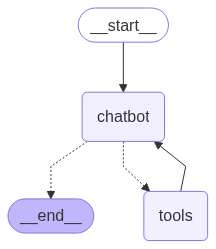

In [199]:
## display the graph

from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(graph.get_graph().draw_mermaid_png()))

In [200]:
## Test the bot with some user queries

In [201]:
#while True:
#  user_input=input("User ")
#  if user_input.lower() in ["quit","buy"]:
#    print("Good Buy")
#    break
#  for event in graph.stream({'messages':("user",user_input)}):
    #print(event.values())
#    for value in event.values():
#      #print(value['messages'])
#      print("Assistant:",value['messages'].content#)

In [205]:
user_input_keyword_set=['hi','hello','good morning','I am','hi, there']
user_input="How to install the docker"
if any(users_input_keywords in user_input for users_input_keywords in user_input_keyword_set):
    print("Hi, How Can  I assist you today")
else:
  events=graph.stream({"messages":[("user",user_input)]}, stream_mode="values")
  for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

How to install the docker
================================== Ai Message ==================================
Tool Calls:
  wikipedia (act598erh)
 Call ID: act598erh
  Args:
    query: how to install docker
================================= Tool Message =================================
Name: wikipedia

Page: Docker (software)
Summary: Docker is a set of platform as a service (PaaS) products that use OS-level virtualization to deliver software in packages called containers. The service has both free and premium tiers. The software that hosts the containers is called Docker Engine. It was first rele
================================== Ai Message ==================================

You can install Docker on your system using the official Docker installation instructions. 

Here's a general overview:

1. **Check System Requirements:** Ensure your system meets Docker's minimum requirements.
2. **Install Docker En